In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Folder path containing audio files
data_dir = '/content/drive/Shareddrives/2022 DOUTORADO Larissa Rodrigues/6 CRISP API/AUDIO/Doritos'

# Change the current working directory
import os
os.chdir(data_dir)

In [29]:
!ls

dados.xlsx	 DoritosD027.wav  DoritosD112.wav  DoritosD235.wav
DoritosD022.wav  DoritosD098.wav  DoritosD130.wav
DoritosD023.wav  DoritosD099.wav  DoritosD189.wav
DoritosD026.wav  DoritosD100.wav  DoritosD192.wav


Ad. Energia Sonora =  3.36739644408226
onset_env= [10.354656  5.54885 ]
Ad. dos Picos de Amplitude =  3.071759343147278


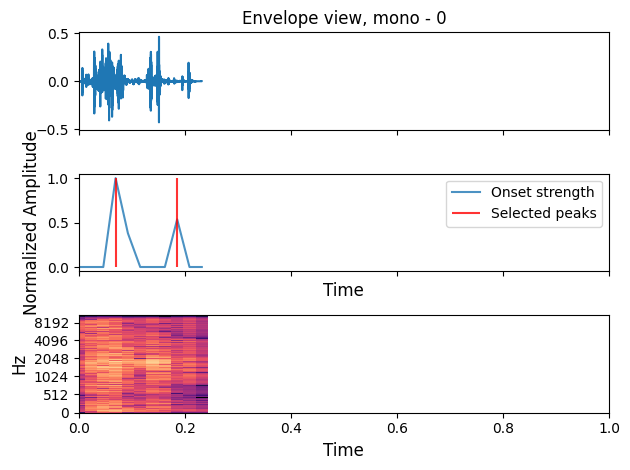

Ad. Energia Sonora =  2.48324628919363
onset_env= [5.6852455 7.396033  2.6240635]
Ad. dos Picos de Amplitude =  6.370445609092712


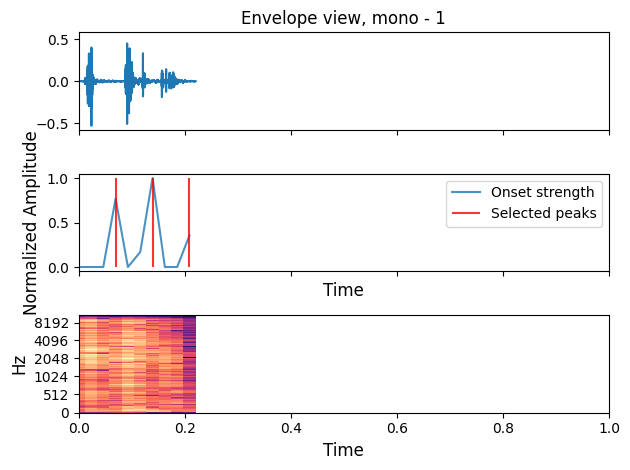

Ad. Energia Sonora =  3.914797678589821
onset_env= [6.533847  0.4921317]
Ad. dos Picos de Amplitude =  2.1506407260894775


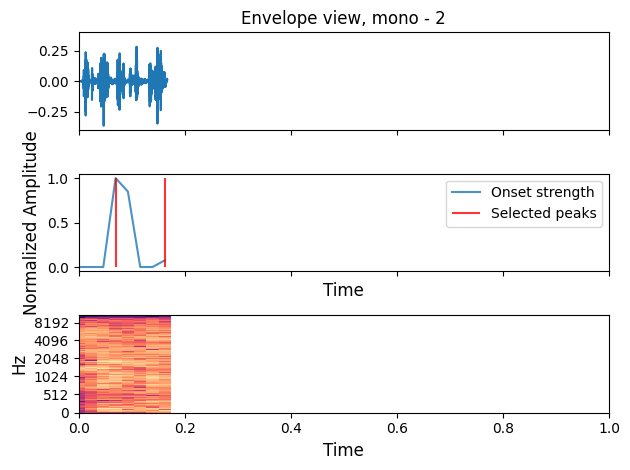

Ad. Energia Sonora =  1.3262087479233742
onset_env= [22.67921  17.853907]
Ad. dos Picos de Amplitude =  3.5744733810424805


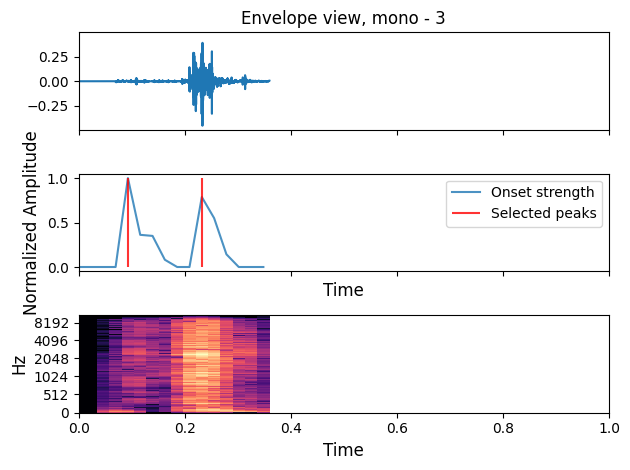

Ad. Energia Sonora =  2.834157273173332
onset_env= [11.925642   0.9429779  6.204762 ]
Ad. dos Picos de Amplitude =  4.79807672649622


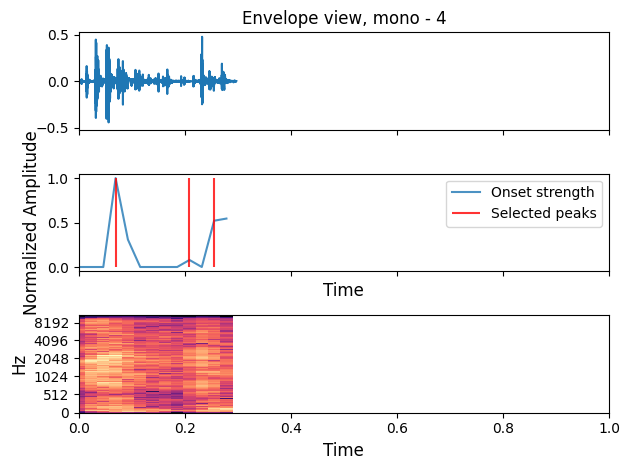

Ad. Energia Sonora =  1.714998111128807
onset_env= [30.88757  16.805426]
Ad. dos Picos de Amplitude =  3.0881675481796265


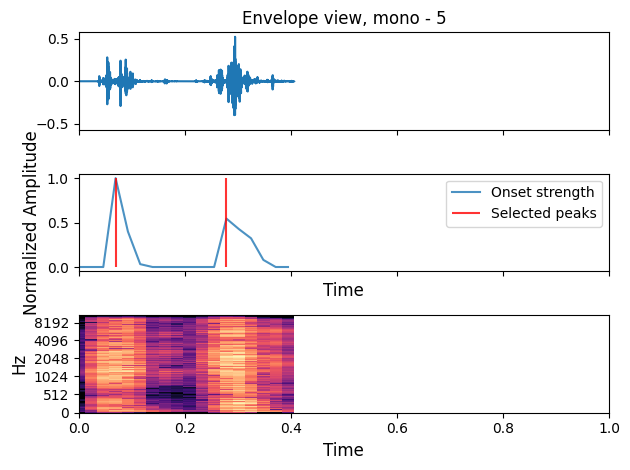

Ad. Energia Sonora =  2.38091591745615
onset_env= [2.0030584 1.1970482 3.4426093 1.991087 ]
Ad. dos Picos de Amplitude =  10.031696319580078


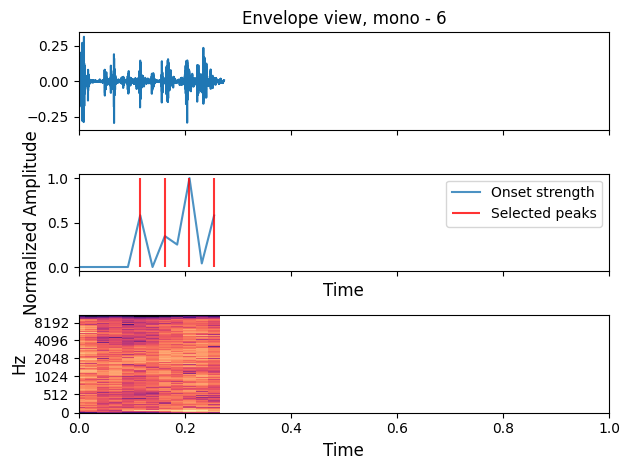

Ad. Energia Sonora =  3.8677968084812164
onset_env= [33.33171  12.402674  5.164086]
Ad. dos Picos de Amplitude =  4.5810853242874146


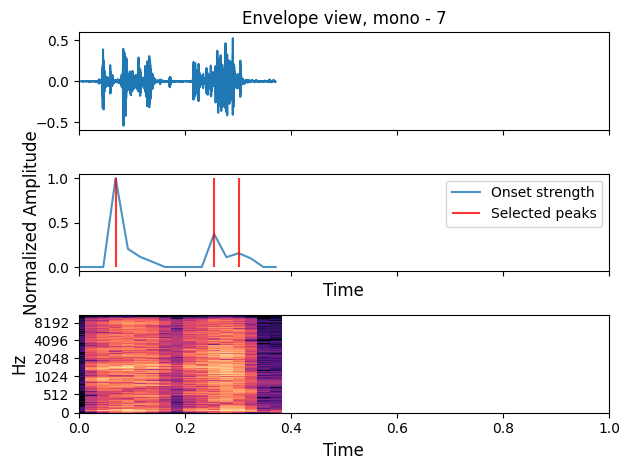

Ad. Energia Sonora =  2.1238118410110474
onset_env= [10.213042  16.56569   10.255131   3.336378   4.852972   6.1194687]
Ad. dos Picos de Amplitude =  18.596031814813614


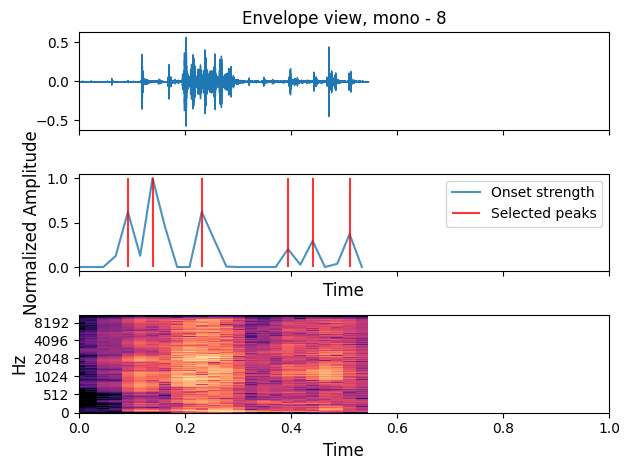

Ad. Energia Sonora =  7.782376557588577
onset_env= [4.228398  7.4192195]
Ad. dos Picos de Amplitude =  3.1398497819900513


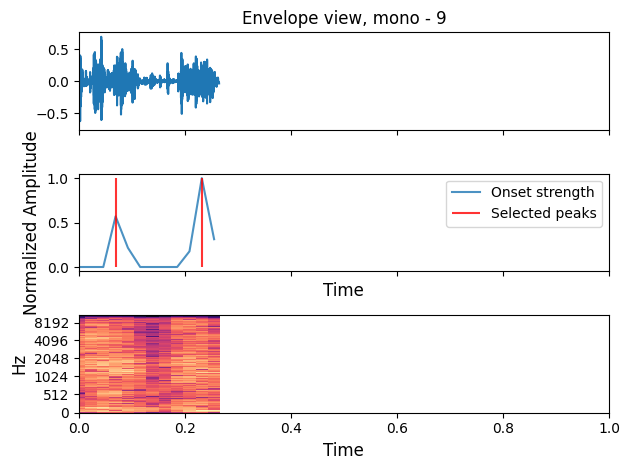

Ad. Energia Sonora =  3.4310970455408096
onset_env= [20.543028   8.772586   1.9064062]
Ad. dos Picos de Amplitude =  4.55950603634119


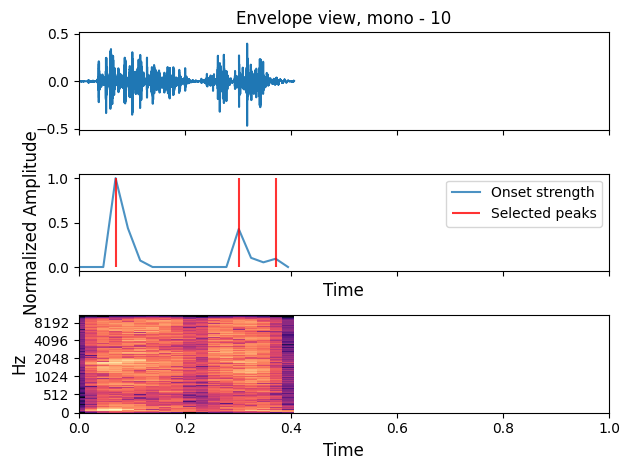

Ad. Energia Sonora =  3.033364564180374
onset_env= [8.715678]
Ad. dos Picos de Amplitude =  1.0


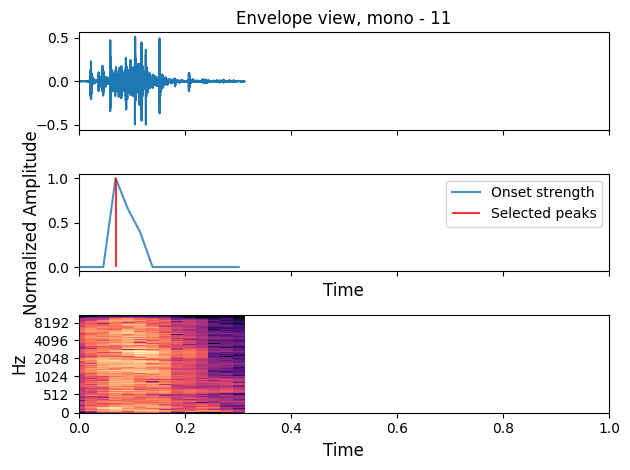

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
from glob import glob

# Folder path containing audio files
#data_dir = '/content/...'
audio_files = glob(data_dir + "/*.wav")

# Create an empty list to hold DataFrames
df_list = []

for file in range(0, len(audio_files), 1):
    y, sr = librosa.load(audio_files[file], duration=1.0)
    time = np.arange(0, len(y)) / sr

    # Ad. energia Sonora
    # Detect the silence regions
    #threshold = 20  # threshold in dB
    #silence_regions = librosa.effects.split(y, top_db=threshold)
    # Remove the silence regions from the audio signal
    #y_trimmed = np.concatenate([y[start:end] for start, end in silence_regions])

    # Unchek to DO NOT remove the silent regions
    y_trimmed = y

    # Compute the energy of each frame
    frame_length = int(sr * 0.01)  # frame length in samples (10 ms frames)
    hop_length = int(sr * 0.005)  # hop length in samples (5 ms hops)
    energy = librosa.feature.rms(y=y_trimmed, frame_length=frame_length, hop_length=hop_length)

    # Compute the median energy
    avg_energy = np.mean(energy) * 100
    print('Ad. Energia Sonora = ', avg_energy)

    # Parameters for peak picking
    pre_max = 1     # Consider peaks close to the current frame
    post_max = 1    # Consider peaks close to the current frame
    pre_avg = 1     # Calculate average from the immediate previous frame
    post_avg = 2    # Calculate average from the immediate next frame
    delta = 0.1     # Lower threshold for peak detection
    wait = 1        # Allow peaks to be detected in consecutive frames

    # Ad. dos picos de Amplitude
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512, aggregate=np.median)
    peaks = librosa.util.peak_pick(
        onset_env, pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)
    times = librosa.times_like(onset_env, sr=sr, hop_length=512)
    print('onset_env=', onset_env[peaks])

    in_sum = onset_env[peaks]
    suma = in_sum / max(in_sum)
    value = sum(suma) * len(suma)
    print('Ad. dos Picos de Amplitude = ', value)
    ons = onset_env / max(onset_env)

    # Criar o DataFrame pro excel
    dc = {'Ad. Energia Sonora': [avg_energy], 'Ad. dos Picos de Amplitude': [value],
          'C Sonoro':[avg_energy*value]}
    df2 = pd.DataFrame(dc)
    df_list.append(df2)

    import matplotlib.pyplot as plt
    y, sr = librosa.load(audio_files[file], duration=10)
    fig, ax = plt.subplots(nrows=3, sharex=True)
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ##ax[0].set(title='Envelope view, mono')
    ax[0].set(title=f'Envelope view, mono - {file}')
    ax[0].label_outer()

    ax[1].plot(times, ons, alpha=0.8, label='Onset strength')
    ax[1].set_ylabel('Normalized Amplitude', fontsize=12)
    ax[1].vlines(times[peaks], 0, ons.max(), color='r', alpha=0.8, label='Selected peaks')
    ax[1].legend(frameon=True, framealpha=0.8)
    ax[1].axis('tight')
    ax[1].set_xlabel('Time', fontsize=12)
    ax[1].set_xlim([0, 1])

    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max), y_axis='mel', x_axis='time', ax=ax[2])
    ax[2].set_xscale('linear')
    ax[2].set_ylabel('Hz', fontsize=12)
    ax[2].set_xlabel('Time', fontsize=12)
    ax[2].set_xlim([0, 1])

    plt.tight_layout()
    #plt.savefig(f'{file}.png')  # Save the figure
    plt.show()

# Concatenate the list of DataFrames into a single DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Drop the first row
df_combined = df_combined.drop(0, axis=0)

# Save the combined DataFrame to Excel
df_combined.to_excel('dados.xlsx', index=False)
